# Model concept
![Hallo](..\sample_data\model_concept.drawio.png)

In [26]:
from helpers.log_config import setup_logging
setup_logging()

import numpy as np
import pandas as pd
from swmm_api.output_file.extract import SwmmOutExtractWarning
import warnings
import matplotlib.pyplot as plt
from src.swmmRouting.routing import Router
from src.swmmRouting.seeding import Seeder

warnings.filterwarnings("ignore", category=SwmmOutExtractWarning)

# Packet routing
This cell creates the packets and routes the packets through the hydraulic network based on the initial model run.

In [27]:
# settings for packet router
model_path = r"..\sample_data\sample_model.inp"
out_path = r"..\sample_data\sample_model.out"
pop_path = r"../sample_data/pop_data.csv"

target_node = "MH3329503824"
start = pd.to_datetime("01.04.2015 00:00", format="%d.%m.%Y %H:%M")
end = pd.to_datetime("01.06.2015 00:00", format="%d.%m.%Y %H:%M")

# pattern for distribution of defecation events, total sum of 1.5 defecations per day
df_defpat = pd.Series(1.5 * np.array([1.4, 0.3, 0.1, 0.0, 0.3, 1.7, 9.1, 21, 13, 9, 6.9, 4.9,
                                     1.9, 3.6, 2.5, 2, 2.9, 2.3, 4.1, 4.0, 2.7, 2.1, 2.2, 2.0])/100)
# number of wipes sent per flush
wipes_per_flush = 5

# prepare seeder
df_population = pd.read_csv(pop_path)
seeder = Seeder(df_seeding_population=df_population, hourly_probability=df_defpat)
seed_table = seeder.generate_seeds(start=start, end=end)

# prepare router
router = Router()
router.get_network_from_inpfile(model_path)
router.get_flows_from_outfile(path_out=out_path, start=start, end=end)

# create seeds and route table
rtable = router.from_seeding_table(seeding_table=seed_table, target=target_node)
routed = router.route_table(rtable)

## Dissipation, Snagging, Accumulation

In [28]:
import random

def fitted_dissipation_rate(X):
    # wipes: n, flow rate: l/s, age: hours
    wipes, flow_rate, age = X
    b1, b2, b3, b4, b5 = [ 0.10194453,  1.23100065, -0.04354149, 10.65112679, -0.38916378]
    return (b1 * wipes + b2 * flow_rate + b3 * wipes * flow_rate + b4) * np.exp(b5 * age)

def snagging_probability(q):
    # q: flow rate in l/s 
    return (-1.0489*q + 97.143) / 100

def snag(flowrate):
    # calculation of whether wipe snags
    q = flowrate
    probability = snagging_probability(q)
    return random.random() < probability

def accum_probability(q):
    # q: flow rate in l/s 
    return (-0.2006*q + 68.174) / 100

def accumulate(flowrate):
    # calculation of whether wipe accumulates
    q = flowrate
    probability = accum_probability(q)
    return random.random() < probability

## Blockage simulation
### prepare data for blockage simulations
calculates the snagging accumulation and inital decay of a blockage based on the initial model run

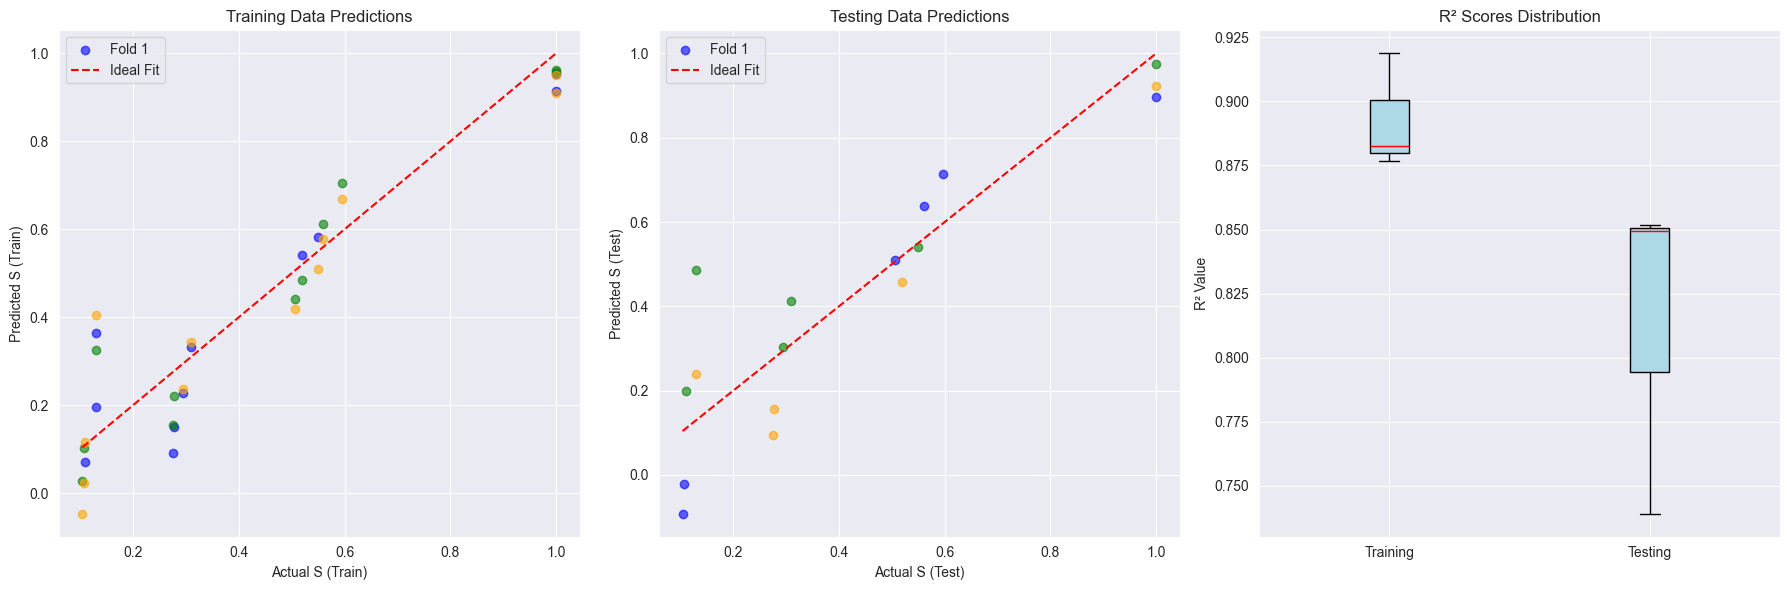

In [41]:
X.shape
#y_obs.shape

(2, 18)

Text(0.02, 0.5, 'Setting [-]')

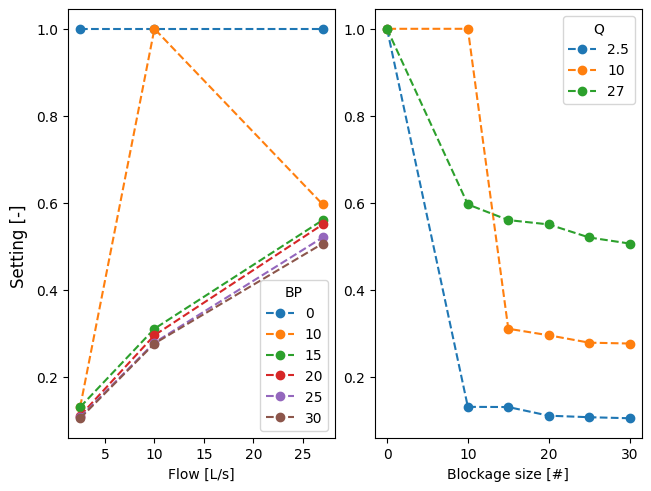

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, constrained_layout=True)

df_settings.groupby("BP").plot(x="Q", y="S", marker="o", ax=axs[0], linestyle="dashed")
axs[0].set(xlabel="Flow [L/s]")
axs[0].legend([0, 10, 15, 20, 25, 30])
axs[0].get_legend().set_title("BP")
df_settings.groupby("Q").plot(x="BP", y="S", marker="o", ax=axs[1], linestyle="dashed")
axs[1].legend([2.5, 10, 27])
axs[1].get_legend().set_title("Q")
axs[1].set(xlabel="Blockage size [#]")
fig.supylabel("Setting [-]")

Text(0, 0.5, 'Q [L/s]')

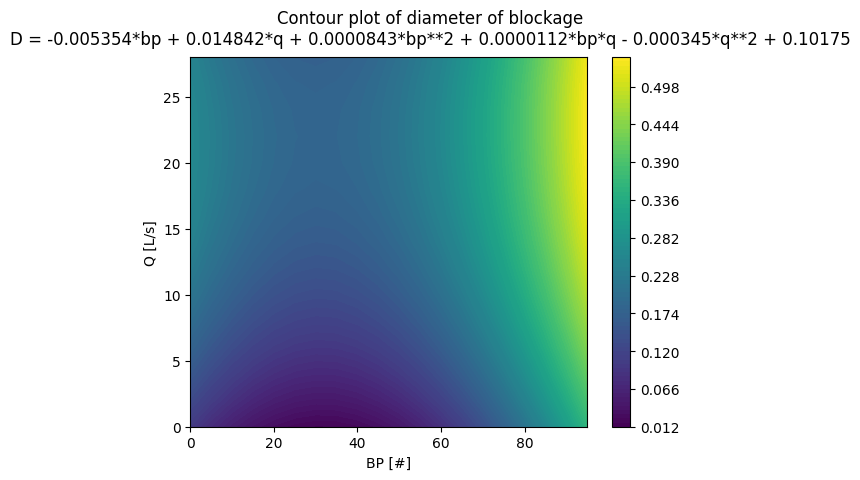

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def block_orifice(bp, q):
    return -0.005354*bp + 0.014842*q + 0.0000843*bp**2 + 0.0000112*bp*q - 0.000345*q**2 + 0.10175

arr_bp = np.arange(0, 100, 5)
arr_q = np.arange(0, 30, 2)

xv, yv = arr_combinations = np.meshgrid(arr_bp, arr_q)

zv = block_orifice(xv, yv)
# Plot the results
fig, ax = plt.subplots()
fig.suptitle("Contour plot of diameter of blockage\nD = -0.005354*bp + 0.014842*q + 0.0000843*bp**2 + 0.0000112*bp*q - 0.000345*q**2 + 0.10175")
# ax = fig.add_subplot(111, projection='3d')
cp = ax.contourf(xv, yv, zv, levels=100, cmap='viridis')
plt.colorbar(cp)

# Set plot labels
ax.set_xlabel('BP [#]')
ax.set_ylabel('Q [L/s]')

$$S = e^{-b_1*BP}$$

In [6]:
s_per_hr = 3600

arrivals = routed[target_node].dropna().sort_values()
rounded_arrivals = arrivals.dt.floor("T")

# create empty pile series
s_arrivals = pd.Series(0, index=pd.date_range(start=start, end=end, freq="1T", inclusive="right"), name="arrivals")
for ts in rounded_arrivals.values:
    if ts in s_arrivals.index:
        s_arrivals.loc[ts] += 1

# get flowrates and reindex to timeseries of arrivals
flowrates = router.df_flows["MH3341403729.1"]
flowrates_reindexed = flowrates.reindex(s_arrivals.index, method="nearest")
flowrates_reindexed = flowrates_reindexed.fillna(0)
# copy arrivals to array
arrivals = s_arrivals.values
# prepare array for pile
pile = np.zeros_like(arrivals, dtype=float)

### calculate first blockage series

In [7]:
accs = 0
for i in range(1, len(pile)):
    # calculate dissipation from previous pile
    pile[i] = pile[i-1] * np.exp(-fitted_dissipation_rate([pile[i-1], flowrates[i], 20])*1/60) 
    # if no pile exists, calculate snagging
    w = arrivals[i]
    while (pile[i] == 0) & (w > 0):
        pile[i] += snag(flowrates[i])
        w -= 1
    # calculate accumulation with remaining arriving wipes
    accumulations = sum([accumulate(flowrates[i]) for _ in range(w)])
    pile[i] += accumulations
    accs += accumulations

s_pile = pd.Series(pile, index=pd.date_range(start=start, end=end, freq="1T", inclusive="right"), name="pile")
print(f"Arrivals: {sum(arrivals)}, accumulations: {accs}")

Arrivals: 57624, accumulations: 39370


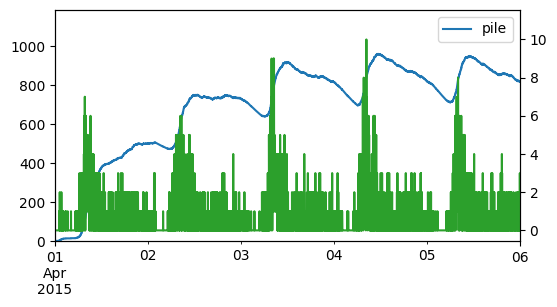

In [13]:
fig, ax = plt.subplots(figsize=[6, 3])
ax1 = ax.twinx()
s_pile.plot(ax=ax, label="pile")
s_arrivals.plot(ax=ax1, label="arrivals", c="tab:green")
ax.set_xlim([pd.to_datetime("01.04.2015 00:00", format="%d.%m.%Y %H:%M"),
         pd.to_datetime("06.04.2015 00:00", format="%d.%m.%Y %H:%M")])
ax.set_ylim([0, 1.2*max(pile)])
ax.legend()

In [14]:
import pandas as pd

# Define the columns in the desired order
columns_in_order = ['column1', 'column2', 'column3', 'column4']

# Create an empty DataFrame with these columns
df1 = pd.DataFrame(columns=columns_in_order)

# Example second DataFrame with additional columns
data = {
    'column1': [1, 2, 3],
    'column2': [4, 5, 6],
    'column3': [7, 8, 9],
    'redundant_column1': ['a', 'b', 'c'],
    'redundant_column2': [True, False, True]
}
df2 = pd.DataFrame(data)

# Reindex df2 to match the columns of df1, filling missing columns with NaN
df2_reindexed = df2.reindex(columns=df1.columns)
print(df2_reindexed)
# Concatenate df1 and df2_reindexed
df1 = pd.concat([df1, df2_reindexed], ignore_index=True)

print(df1)

   column1  column2  column3  column4
0        1        4        7      NaN
1        2        5        8      NaN
2        3        6        9      NaN
  column1 column2 column3 column4
0       1       4       7     NaN
1       2       5       8     NaN
2       3       6       9     NaN


# Evaluation

In [10]:
from swmm_api import read_out_file
from swmm_api.output_file import VARIABLES as swmm_vars
from swmm_api.output_file import OBJECTS as swmm_objs

## get pile size over time

In [104]:
out = read_out_file(out_path)
df_flows = out.get_part(kind=swmm_objs.LINK, variable=swmm_vars.LINK.FLOW)
df_velocities = out.get_part(kind=swmm_objs.LINK, variable=swmm_vars.LINK.VELOCITY)

In [105]:
fig, ax = plt.subplots()
df_flows["MH3295504178.1"].plot(label="flow rate", ax=ax)
ax.set_ylabel("flow rate [L/s]")
# ax2 = ax.twinx()
# df_velocities["MH3295504178.1"].plot(label="velocities", ax=ax2)
# ax2.set_ylabel("velocities [m/s]")

In [103]:
fig, axs = plt.subplots(ncols=2)
df_flows.loc["2015-04-02 00:00":"2015-04-02 00:05","MH3295504178.1"].plot(marker="o", ax=axs[0])
times = pd.to_datetime(["2015-04-02 00:00:10", "2015-04-02 00:01:30", "2015-04-02 00:02:50", "2015-04-02 00:03:50"])
flows = np.interp(times.astype(np.int64).values/1e9, df_flows["MH3295504178.1"].index.astype(np.int64)/1e9, df_flows["MH3295504178.1"].values)
df_interp = pd.DataFrame(flows, index=times)
df_interp.plot(ax=axs[1], color="tab:red", marker="x", markersize=20, zorder=20
# plt.scatter(times, 9.07*np.ones([4]), color="tab:red")

In [85]:
orig = df_flows.loc[["2015-04-02 00:00","2015-04-02 00:01"],"MH3295504178.1"]
xp = df_flows.loc[["2015-04-02 00:00","2015-04-02 00:01"],"MH3295504178.1"].index
fp = df_flows.loc[["2015-04-02 00:00","2015-04-02 00:01"],"MH3295504178.1"].values
x = pd.to_datetime("2015-04-02 00:00:30")
print(fp[0], np.interp(x.value / 1e9, xp.astype(np.int64)/1e9, fp), fp[1])

In [76]:
[pd.to_datetime("2015-04-02 00:00:30")]

In [55]:
columns = ["log_time", "logger", "level", "sim_time", "variable", "value"]
df_log = pd.read_csv(r"../helpers/application.log", sep=";", skiprows=15)
df_log.columns = columns
# df_log["log_time"] = pd.to_datetime(df_log["log_time"])
df_pile_size = df_log.loc[df_log["variable"]=="pile size", ["sim_time", "value"]]
df_pile_size["sim_time"] = pd.to_datetime(df_pile_size["sim_time"])

fig, ax = plt.subplots()
df_pile_size.set_index("sim_time").plot(ax=ax)
ax.set_xlim([df_flows.index[0], df_flows.index[-1]])

In [42]:
df_flows.index[-1]